In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
import pandas as pd
from datetime import datetime, time
import numpy as np
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import lightgbm as lgb
!pip3 install catboost
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor


plt.style.use('ggplot')

In [28]:
df = pd.read_csv('/content/drive/MyDrive/trabalho_pratico/Dataset_publico.csv', delimiter=';',index_col="ID")


In [29]:
df = df.dropna()

## MODELAGEM DOS DADOS

In [30]:
df["TS_INC_EPR"] = pd.to_datetime(df["TS_INC_EPR"])
df["TS_INC_CHMD"] = pd.to_datetime(df["TS_INC_CHMD"])

In [31]:
#Criando variáveis de interesse
df['HH_INC'] = df['TS_INC_EPR'].dt.strftime('%H').astype('int')
df["DiaSem"] = df['TS_INC_EPR'].dt.strftime('%a')
df["Dia"] = df['TS_INC_EPR'].dt.strftime('%-d')
df["Data"] = df['TS_INC_EPR'].dt.strftime('%x')
df["Mes"] = df['TS_INC_EPR'].dt.strftime('%B')
df["Espera"] = df["TS_INC_CHMD"]- df['TS_INC_EPR']

In [32]:
#Conforme caracterização do problema criando variável categórica para identificar atendimentos com tempo superior a 15min
df["Estouro"] = np.where(df.Espera.dt.total_seconds() > 900 , 1, 0)

In [33]:
#drop dezembro dia 24
start_date = pd.to_datetime('12/24/2020 00:00')
end_date = pd.to_datetime('12/24/2020 23:59')

df.drop(df.loc[(df['TS_INC_EPR'] > start_date) & (df['TS_INC_EPR'] < end_date)].index, inplace=True)

In [34]:
#Conforme caracterização do problema alterando atendimentos iniciados antes do horário de atendimento e após o horário de atendimento para serem contabilizados como dentro do horário
conditions = [
    (df['HH_INC'] < 10),
    (df['HH_INC'] > 14),
    ]

# lista de valores para comparar com condição
values = [10, 14]

# nova coluna com valores que satisfaçam condição
df['HH'] = np.select(conditions, values)

# Novo Dataframe
df.tail()

,ID_UOR,TS_INC_EPR,TS_INC_CHMD,HH_INC,DiaSem,Dia,Data,Mes,Espera,Estouro,HH
ID,,,,,,,,,,,
376677,24,2021-07-30 13:05:56,2021-07-30 13:06:35,13,Fri,30,07/30/21,July,0 days 00:00:39,0,0
376678,24,2021-07-30 13:12:09,2021-07-30 13:15:53,13,Fri,30,07/30/21,July,0 days 00:03:44,0,0
376679,24,2021-07-30 13:17:08,2021-07-30 13:17:31,13,Fri,30,07/30/21,July,0 days 00:00:23,0,0
376680,24,2021-07-30 13:27:15,2021-07-30 13:27:29,13,Fri,30,07/30/21,July,0 days 00:00:14,0,0
376681,24,2021-07-30 13:30:20,2021-07-30 13:34:28,13,Fri,30,07/30/21,July,0 days 00:04:08,0,0


In [35]:
#Transformando horários que foram alterados no passo anterior
df['HH'] = np.where(df.HH == 0, df.HH_INC, df.HH)

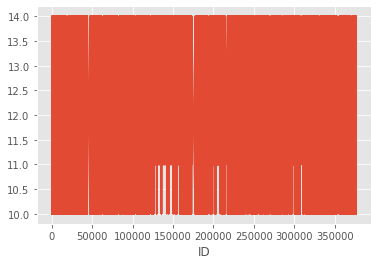

In [ ]:
#confirmando que todos os atendimentos estão entre 10h e 14h
df.HH.plot()

In [36]:
#Groupby dos atendimentos realizados no dia por horário
df2 = df.groupby(["ID_UOR",'Data','HH', 'Dia', 'DiaSem','Mes']).agg({'Estouro':['sum', 'count']})
a = df2.unstack().stack().reset_index()
a.columns = ['ID_UOR','Data','HH','Dia','DiaSem','Mes', 'sum','count']


In [37]:
#Cálculo do percentual de atendimentos que ficou acima do prazo
a['PC_ACI_PZ'] = round((a['sum'] / a['count']) * 100, 2)
abt = a[['ID_UOR', 'HH', 'Dia', 'DiaSem', 'Mes']].astype('str')
abt['PC_ACI_PZ'] = a['PC_ACI_PZ']

In [38]:
#Feature engineering - adicionando percentual de atendimentos fora do prazo para determinado dia da semana, dia do mês e mês
#Objetivo é identificar padrões de demanda para essas variáveis
MEDIA_DIA_SEMANA = abt.groupby(["ID_UOR",'HH', 'DiaSem']).mean('PC_ACI_PZ').unstack().stack().reset_index()
MEDIA_MES = abt.groupby(["ID_UOR",'HH', 'Mes']).mean('PC_ACI_PZ').unstack().stack().reset_index()
MEDIA_DIA = abt.groupby(["ID_UOR",'HH', 'Dia']).mean('PC_ACI_PZ').unstack().stack().reset_index()

MIN_DIA_SEMANA = abt.groupby(["ID_UOR",'HH', 'DiaSem']).min('PC_ACI_PZ').unstack().stack().reset_index()
MIN_MES = abt.groupby(["ID_UOR",'HH', 'Mes']).min('PC_ACI_PZ').unstack().stack().reset_index()
MIN_DIA = abt.groupby(["ID_UOR",'HH', 'Dia']).min('PC_ACI_PZ').unstack().stack().reset_index()

MAX_DIA_SEMANA = abt.groupby(["ID_UOR",'HH', 'DiaSem']).max('PC_ACI_PZ').unstack().stack().reset_index()
MAX_MES = abt.groupby(["ID_UOR",'HH', 'Mes']).max('PC_ACI_PZ').unstack().stack().reset_index()
MAX_DIA = abt.groupby(["ID_UOR",'HH', 'Dia']).max('PC_ACI_PZ').unstack().stack().reset_index()

MEDIA_DIA_SEMANA.columns = ['ID_UOR', 'HH', 'DiaSem', 'PC_ACI_PZ_SMN']
MEDIA_DIA.columns = ['ID_UOR', 'HH', 'Dia', 'PC_ACI_PZ_DIA']
MEDIA_MES.columns = ['ID_UOR', 'HH', 'Mes', 'PC_ACI_PZ_MES']

MIN_DIA_SEMANA.columns = ['ID_UOR', 'HH', 'DiaSem', 'PC_ACI_PZ_MINSMN']
MIN_DIA.columns = ['ID_UOR', 'HH', 'Dia', 'PC_ACI_PZ_MINDIA']
MIN_MES.columns = ['ID_UOR', 'HH', 'Mes', 'PC_ACI_PZ_MINMES']


MAX_DIA_SEMANA.columns = ['ID_UOR', 'HH', 'DiaSem', 'PC_ACI_PZ_MAXSMN']
MAX_DIA.columns = ['ID_UOR', 'HH', 'Dia', 'PC_ACI_PZ_MAXDIA']
MAX_MES.columns = ['ID_UOR', 'HH', 'Mes', 'PC_ACI_PZ_MAXMES']

In [ ]:
abt.head(1)

,ID_UOR,HH,Dia,DiaSem,Mes,PC_ACI_PZ
0,0,10,4,Mon,January,0.0


## Comportamento Demanda Mensal

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


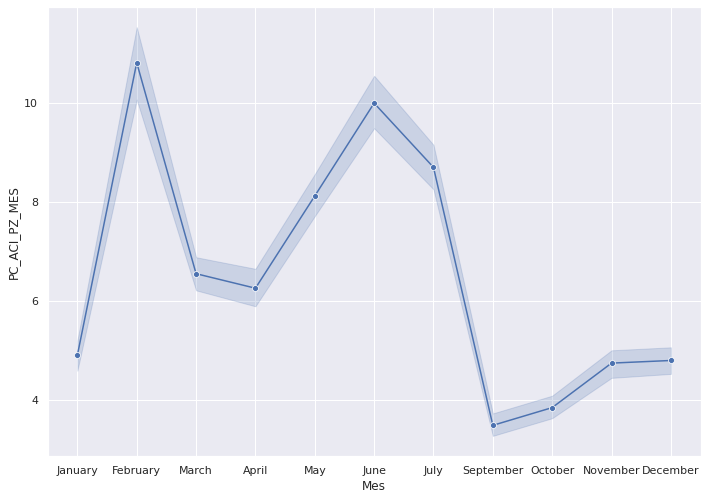

In [27]:

sns.set(rc={'figure.figsize':(11.7,8.27)})
abt['Mes'] = pd.Categorical(abt['Mes'], categories=['January', 'February', 'March', 'April','May', 'June', 'July','September', 'October', 'November',  'December'], ordered=True)
sns.lineplot(abt.Mes, abt.PC_ACI_PZ_MES, marker='o')


##JOIN

In [39]:
abt = pd.merge(abt, MEDIA_DIA_SEMANA, on=['ID_UOR', 'HH', 'DiaSem'])
abt = pd.merge(abt, MEDIA_DIA, on=["ID_UOR",'HH', 'Dia'])
abt = pd.merge(abt, MEDIA_MES, on=["ID_UOR",'HH', 'Mes'])

abt = pd.merge(abt, MIN_DIA_SEMANA, on=['ID_UOR', 'HH', 'DiaSem'])
abt = pd.merge(abt, MIN_DIA, on=["ID_UOR",'HH', 'Dia'])
abt = pd.merge(abt, MIN_MES, on=["ID_UOR",'HH', 'Mes'])

abt = pd.merge(abt, MAX_DIA_SEMANA, on=['ID_UOR', 'HH', 'DiaSem'])
abt = pd.merge(abt, MAX_DIA, on=["ID_UOR",'HH', 'Dia'])
abt = pd.merge(abt, MAX_MES, on=["ID_UOR",'HH', 'Mes'])

In [40]:
abt.head()

,ID_UOR,HH,Dia,DiaSem,Mes,PC_ACI_PZ,PC_ACI_PZ_SMN,PC_ACI_PZ_DIA,PC_ACI_PZ_MES,PC_ACI_PZ_MINSMN,PC_ACI_PZ_MINDIA,PC_ACI_PZ_MINMES,PC_ACI_PZ_MAXSMN,PC_ACI_PZ_MAXDIA,PC_ACI_PZ_MAXMES
0,0,10,4,Mon,January,0.00,3.347907,6.690000,1.5705,0.0,0.0,0.0,22.22,40.00,23.08
1,0,10,11,Mon,January,0.00,3.347907,3.541250,1.5705,0.0,0.0,0.0,22.22,20.00,23.08
2,0,10,18,Mon,January,0.00,3.347907,5.745000,1.5705,0.0,0.0,0.0,22.22,28.57,23.08
3,0,10,25,Mon,January,8.33,3.347907,5.951429,1.5705,0.0,0.0,0.0,22.22,33.33,23.08
4,0,10,7,Thu,January,0.00,2.970667,1.098571,1.5705,0.0,0.0,0.0,33.33,7.69,23.08


##DUMMIES

In [41]:
abt = pd.get_dummies(abt, prefix=['ID_UOR', 'HH', 'Dia', 'DiaSem','Mes'])

## Train Test split + sklearn imports

In [42]:


X = abt.iloc[:,1:]
y = abt['PC_ACI_PZ']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)



     |████████████████████████████████| 76.3 MB 33 kB/s 


## LGBM

In [ ]:

clf = lgb.LGBMRegressor()
clf.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
#RESULTADO COM MÉDIA DO MÊS
y_pred=clf.predict(X_test)
y_pred_train = clf.predict(X_train)

print(metrics.r2_score(y_train, y_pred_train))
print(metrics.mean_absolute_error(y_train, y_pred_train))
print(metrics.mean_squared_error(y_train, y_pred_train))
print('---------------------------------------------------')
print(metrics.r2_score(y_test, y_pred))
print(metrics.mean_absolute_error(y_test, y_pred))
print(metrics.mean_squared_error(y_test, y_pred))

0.7133911262736912
4.608754210800728
73.96131736868968
---------------------------------------------------
0.5207606703662214
5.905072110995992
134.33932655747063


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


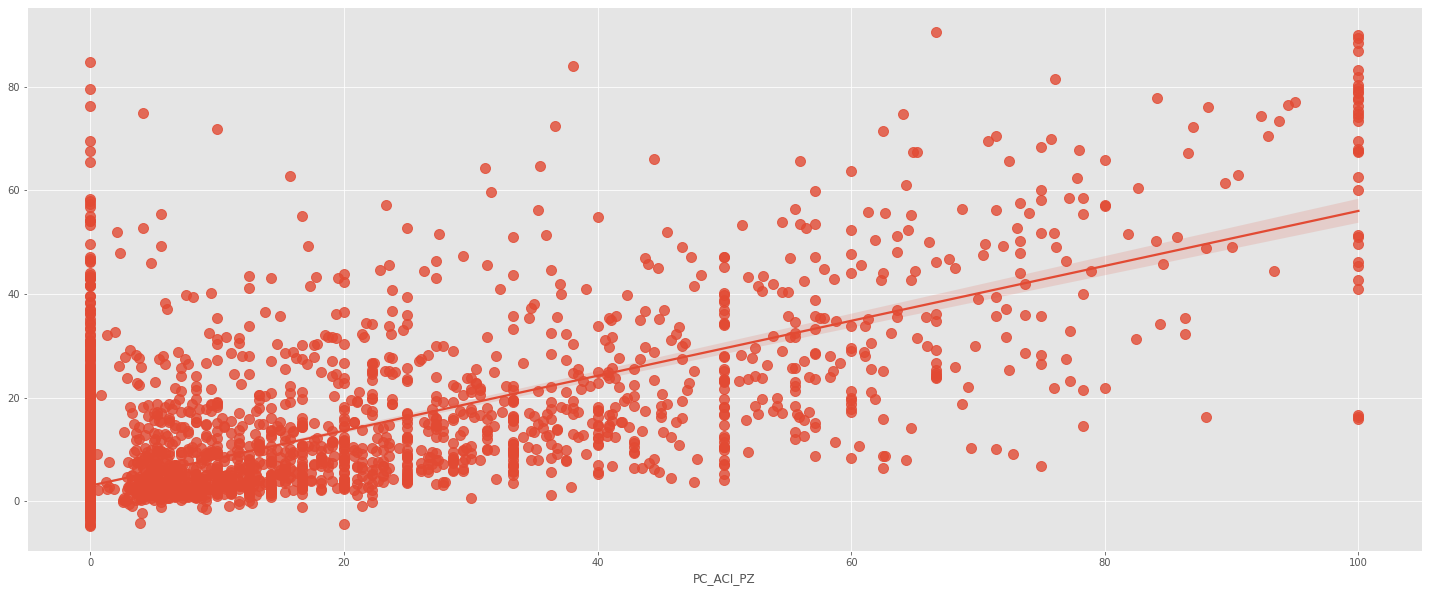

In [ ]:
plt.figure(figsize=(25,10))
sns.regplot(y_test, y_pred, fit_reg=True, scatter_kws={"s": 100})

##LGBM otimização

In [ ]:


parametros = {
    'max_depth' : [-1],
    'num_leaves' : [20, 31, 50],
    'learning_rate' : [0.01, 0.1],
    'n_estimators' : [500, 600, 700]
}

lgbm_model_tunned = GridSearchCV(clf, parametros, verbose=2, scoring = 'neg_mean_squared_error', cv=5, n_jobs=-1)
lgbm_model_tunned.fit(X_train,y_train)

NameError: ignored

In [ ]:
best_params = lgbm_model_tunned.best_params_
print(f'Hiperparâmetros = {best_params}')

Hiperparâmetros = {'learning_rate': 0.01, 'max_depth': -1, 'n_estimators': 500, 'num_leaves': 31}


In [ ]:
y_pred_tunned = lgbm_model_tunned.predict(X_test)

print(metrics.r2_score(y_test, y_pred_tunned))
print(metrics.mean_absolute_error(y_test, y_pred_tunned))
print(metrics.mean_squared_error(y_test, y_pred))

0.5236760230068935
5.948145251789212
134.33932655747063


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


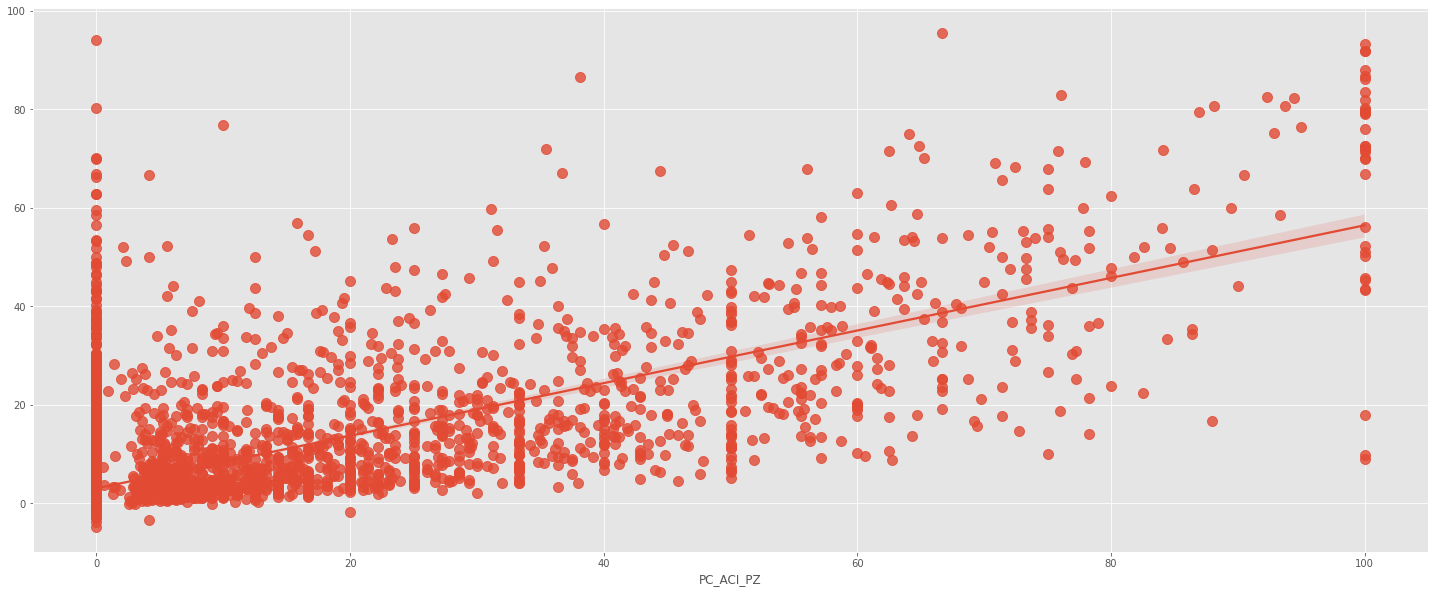

In [ ]:
plt.figure(figsize=(25,10))
sns.regplot(y_test, y_pred_tunned, fit_reg=True, scatter_kws={"s": 100})

##CATBOOST

In [44]:
model = CatBoostRegressor()
# Fit model
model.fit(X_train, y_train)
# Get predictions
preds = model.predict(X_test)
print(metrics.mean_squared_error(y_test, preds))


Learning rate set to 0.062516
0:	learn: 15.6516702	total: 53ms	remaining: 52.9s
1:	learn: 15.2876039	total: 57.8ms	remaining: 28.9s
2:	learn: 14.9881064	total: 62.8ms	remaining: 20.9s
3:	learn: 14.7061417	total: 67.4ms	remaining: 16.8s
4:	learn: 14.4180294	total: 72.1ms	remaining: 14.3s
5:	learn: 14.1636360	total: 76.9ms	remaining: 12.7s
6:	learn: 13.9258946	total: 81.3ms	remaining: 11.5s
7:	learn: 13.7108610	total: 86ms	remaining: 10.7s
8:	learn: 13.5339474	total: 90.7ms	remaining: 9.98s
9:	learn: 13.3633713	total: 95.4ms	remaining: 9.45s
10:	learn: 13.2139129	total: 100ms	remaining: 9s
11:	learn: 13.0744626	total: 105ms	remaining: 8.63s
12:	learn: 12.9027032	total: 109ms	remaining: 8.31s
13:	learn: 12.7857052	total: 114ms	remaining: 8.04s
14:	learn: 12.6483849	total: 119ms	remaining: 7.81s
15:	learn: 12.5457800	total: 124ms	remaining: 7.61s
16:	learn: 12.4208996	total: 128ms	remaining: 7.43s
17:	learn: 12.3422193	total: 133ms	remaining: 7.28s
18:	learn: 12.2833890	total: 137ms	remain

In [49]:
parametros = {
    
    'num_leaves' : [20, 31, 50],
    'learning_rate' : [0.01, 0.05, 0.1],
    'n_estimators' : [500, 600, 700],
    'depth': [4, 6, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 9]
}

cat_model_tunned = GridSearchCV(model, parametros, verbose=2, scoring = 'neg_mean_squared_error', cv=5, n_jobs=-1)
cat_model_tunned.fit(X_train,y_train)

Fitting 5 folds for each of 405 candidates, totalling 2025 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed: 33.4min
[Parallel(n_jobs=-1)]: Done 1981 tasks      | elapsed: 85.0min
[Parallel(n_jobs=-1)]: Done 2025 out of 2025 | elapsed: 89.5min finished


0:	learn: 15.7376037	total: 7.3ms	remaining: 3.64s
1:	learn: 15.4483377	total: 12.5ms	remaining: 3.11s
2:	learn: 15.1995536	total: 17.1ms	remaining: 2.84s
3:	learn: 14.9586659	total: 21.7ms	remaining: 2.7s
4:	learn: 14.7186336	total: 26.3ms	remaining: 2.6s
5:	learn: 14.4974878	total: 31ms	remaining: 2.55s
6:	learn: 14.3086907	total: 35.4ms	remaining: 2.49s
7:	learn: 14.1069524	total: 40ms	remaining: 2.46s
8:	learn: 13.9361284	total: 44.7ms	remaining: 2.44s
9:	learn: 13.7745333	total: 49.4ms	remaining: 2.42s
10:	learn: 13.6287778	total: 54.2ms	remaining: 2.41s
11:	learn: 13.4906189	total: 59.2ms	remaining: 2.41s
12:	learn: 13.3378266	total: 63.9ms	remaining: 2.39s
13:	learn: 13.1973620	total: 68.4ms	remaining: 2.37s
14:	learn: 13.0883712	total: 72.8ms	remaining: 2.35s
15:	learn: 12.9812013	total: 77.3ms	remaining: 2.34s
16:	learn: 12.8880164	total: 82ms	remaining: 2.33s
17:	learn: 12.7906351	total: 86.9ms	remaining: 2.33s
18:	learn: 12.7082709	total: 91.4ms	remaining: 2.31s
19:	learn: 1

GridSearchCV(cv=5, error_score=nan,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f62629316d0>,
             iid='deprecated', n_jobs=-1,
             param_grid={'depth': [4, 6, 10], 'l2_leaf_reg': [1, 3, 5, 7, 9],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'n_estimators': [500, 600, 700],
                         'num_leaves': [20, 31, 50]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=2)

In [50]:
best_params = cat_model_tunned.best_params_
print(f'Hiperparâmetros = {best_params}')
preds = cat_model_tunned.predict(X_test)
print(metrics.mean_squared_error(y_test, preds))

Hiperparâmetros = {'depth': 6, 'l2_leaf_reg': 7, 'learning_rate': 0.05, 'n_estimators': 500, 'num_leaves': 31}
125.28984637451973


## DEEP LEARNING

In [ ]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.embeddings import Embedding

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import mean_absolute_error

In [ ]:
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 10, 
                                        restore_best_weights = True)

In [ ]:
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

model = Sequential()

model.add(Dense(100))
model.add(Dense(50, activation="relu", kernel_regularizer='l2'))
model.add(Dense(10, activation="relu", kernel_regularizer='l2'))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='rmsprop',loss=root_mean_squared_error, metrics=["accuracy"])
model.fit(X_train, y_train, epochs=1000, verbose=2, batch_size=16, validation_data=(X_test, y_test),callbacks =[earlystopping])

Epoch 1/1000
911/911 - 3s - loss: 12.0053 - accuracy: 0.3745 - val_loss: 11.6331 - val_accuracy: 0.4860
Epoch 2/1000
911/911 - 2s - loss: 11.2804 - accuracy: 0.3769 - val_loss: 11.7397 - val_accuracy: 0.5840
Epoch 3/1000
911/911 - 1s - loss: 11.0642 - accuracy: 0.3750 - val_loss: 11.4965 - val_accuracy: 0.2225
Epoch 4/1000
911/911 - 2s - loss: 10.9255 - accuracy: 0.3695 - val_loss: 10.9192 - val_accuracy: 0.4551
Epoch 5/1000
911/911 - 2s - loss: 10.7570 - accuracy: 0.3691 - val_loss: 10.8983 - val_accuracy: 0.5395
Epoch 6/1000
911/911 - 2s - loss: 10.5513 - accuracy: 0.3786 - val_loss: 11.3208 - val_accuracy: 0.4078
Epoch 7/1000
911/911 - 2s - loss: 10.4758 - accuracy: 0.3796 - val_loss: 10.8464 - val_accuracy: 0.5111
Epoch 8/1000
911/911 - 1s - loss: 10.3475 - accuracy: 0.3697 - val_loss: 10.7167 - val_accuracy: 0.3029
Epoch 9/1000
911/911 - 1s - loss: 10.3498 - accuracy: 0.3770 - val_loss: 10.6756 - val_accuracy: 0.3697
Epoch 10/1000
911/911 - 1s - loss: 10.2324 - accuracy: 0.3750 - 

In [ ]:
y_test_deep_pred = model.predict(X_test)
y_train_deep_pred = model.predict(X_train)

### 1000 epoch earlystopping 10 patience 100 50 10 1

In [ ]:
#200 100 50 10 1 patience=10
mae_test_deep = mean_absolute_error(y_test, y_test_deep_pred)
print(metrics.r2_score(y_test, y_test_deep_pred))
print("MAE Deep Learning (Test): ", mae_test_deep)

0.5887649341499421
MAE Deep Learning (Test):  5.3376709857390665


In [ ]:
mae_test_deep = mean_absolute_error(y_test, y_test_deep_pred)
print(metrics.r2_score(y_test, y_test_deep_pred))
print("MAE Deep Learning (Test): ", mae_test_deep)
print(metrics.mean_squared_error(y_test, y_test_deep_pred))


0.5887649341499421
MAE Deep Learning (Test):  5.3376709857390665
115.27651924004357


### TESTE DIFERENTES PARÂMETROS

In [ ]:
mae_test_deep = mean_absolute_error(y_test, y_test_deep_pred)
print(metrics.r2_score(y_test, y_test_deep_pred))
print("MAE Deep Learning (Test): ", mae_test_deep)

0.35850384533568835
MAE Deep Learning (Test):  5.379709279911829


In [ ]:
#300epoch
mae_test_deep = mean_absolute_error(y_test, y_test_deep_pred)
print(metrics.r2_score(y_test, y_test_deep_pred))
print("MAE Deep Learning (Test): ", mae_test_deep)

0.5036544527621416
MAE Deep Learning (Test):  4.79940943819177


In [ ]:
#1000epoch 10 patience
mae_test_deep = mean_absolute_error(y_test, y_test_deep_pred)
print(metrics.r2_score(y_test, y_test_deep_pred))
print("MAE Deep Learning (Test): ", mae_test_deep)

0.5302412098793715
MAE Deep Learning (Test):  4.7778134950829365


In [ ]:
#MELHOR RESULTADO COM MÊS
mae_test_deep = mean_absolute_error(y_test, y_test_deep_pred)
print(metrics.r2_score(y_test, y_test_deep_pred))
print("MAE Deep Learning (Test): ", mae_test_deep)

0.5112900061483778
MAE Deep Learning (Test):  4.740018016894911


In [ ]:
#RESULTADO RETIRANDO MÉDIA MESES
mae_test_deep = mean_absolute_error(y_test, y_test_deep_pred)
print(metrics.r2_score(y_test, y_test_deep_pred))
print("MAE Deep Learning (Test): ", mae_test_deep)

0.14369639506699317
MAE Deep Learning (Test):  6.410119758122885


In [ ]:
#100 epoch 100 50 50 20 1
mae_test_deep = mean_absolute_error(y_test, y_test_deep_pred)
print(metrics.r2_score(y_test, y_test_deep_pred))
print("MAE Deep Learning (Test): ", mae_test_deep)

0.44649762018761185
MAE Deep Learning (Test):  5.15853877822357


# Submissão

In [144]:
sub = pd.read_csv('/content/drive/MyDrive/trabalho_pratico/X.csv', delimiter=';',index_col="ID")

In [145]:
sub["DT"] = pd.to_datetime(sub["DT"])
sub["HH_INC"] = pd.to_datetime(sub["HH_INC"])

Como não havia o mês de Agosto na amostra havia a opção de descartar os valores médios dos meses mas houve uma piora significativa do modelo. Por esse motivo optei por realizar a submissão utilizando os dados históricos do mês anterior e do próximo mês. Pelo estudo da amostra o mais provável é que o mês de agosto apresentasse uma ligeira redução em relação ao mês de Julho e fosse ligeiramente superior ao mês de Setembro. 

In [146]:
sub['HH'] = sub['HH_INC'].dt.strftime('%H')
sub["DiaSem"] = sub['DT'].dt.strftime('%a')
sub["Dia"] = sub['DT'].dt.strftime('%-d')

sub2 = sub.copy()

In [147]:
sub["Mes"] = 'July'
sub2["Mes"] = 'September'

In [148]:
sub.drop(['DT', 'HH_INC', 'HH_FIM'], axis=1, inplace=True)

In [149]:
sub2.drop(['DT', 'HH_INC', 'HH_FIM'], axis=1, inplace=True)

In [150]:
sub = sub[['ID_UOR', 'HH', 'DiaSem', 'Dia', 'Mes']].astype('str')
sub2 = sub2[['ID_UOR', 'HH', 'DiaSem', 'Dia', 'Mes']].astype('str')

In [151]:
#TRATAR DIA DO MÊS SEM DADOS PARA JULHO
sub = pd.merge(sub, MEDIA_DIA_SEMANA, on=['ID_UOR', 'HH', 'DiaSem'],how='left')
sub = pd.merge(sub, MEDIA_DIA, on=["ID_UOR",'HH', 'Dia'],how='left')
sub = pd.merge(sub, MEDIA_MES, on=["ID_UOR",'HH', 'Mes'],how='left')


sub = pd.merge(sub, MIN_DIA_SEMANA, on=['ID_UOR', 'HH', 'DiaSem'],how='left')
sub = pd.merge(sub, MIN_DIA, on=["ID_UOR",'HH', 'Dia'],how='left')
sub = pd.merge(sub, MIN_MES, on=["ID_UOR",'HH', 'Mes'],how='left')


sub = pd.merge(sub, MAX_DIA_SEMANA, on=['ID_UOR', 'HH', 'DiaSem'],how='left')
sub = pd.merge(sub, MAX_DIA, on=["ID_UOR",'HH', 'Dia'],how='left')
sub = pd.merge(sub, MAX_MES, on=["ID_UOR",'HH', 'Mes'],how='left')



In [152]:
sub2 = pd.merge(sub2, MEDIA_DIA_SEMANA, on=['ID_UOR', 'HH', 'DiaSem'],how='left')
sub2 = pd.merge(sub2, MEDIA_DIA, on=["ID_UOR",'HH', 'Dia'],how='left')
sub2 = pd.merge(sub2, MEDIA_MES, on=["ID_UOR",'HH', 'Mes'],how='left')


sub2 = pd.merge(sub2, MIN_DIA_SEMANA, on=['ID_UOR', 'HH', 'DiaSem'],how='left')
sub2 = pd.merge(sub2, MIN_DIA, on=["ID_UOR",'HH', 'Dia'],how='left')
sub2 = pd.merge(sub2, MIN_MES, on=["ID_UOR",'HH', 'Mes'],how='left')


sub2 = pd.merge(sub2, MAX_DIA_SEMANA, on=['ID_UOR', 'HH', 'DiaSem'],how='left')
sub2 = pd.merge(sub2, MAX_DIA, on=["ID_UOR",'HH', 'Dia'],how='left')
sub2 = pd.merge(sub2, MAX_MES, on=["ID_UOR",'HH', 'Mes'],how='left')


In [ ]:
sub.isnull().sum()

ID_UOR                0
HH                    0
DiaSem                0
Dia                   0
Mes                   0
PC_ACI_PZ_SMN        74
PC_ACI_PZ_DIA       180
PC_ACI_PZ_MES       286
PC_ACI_PZ_MINSMN     74
PC_ACI_PZ_MINDIA    180
PC_ACI_PZ_MINMES    286
PC_ACI_PZ_MAXSMN     74
PC_ACI_PZ_MAXDIA    180
PC_ACI_PZ_MAXMES    286
dtype: int64

In [153]:
#Preencher campos sem informação com a média dos demais dados da amostra
sub['PC_ACI_PZ_SMN'].fillna((sub['PC_ACI_PZ_SMN'].mean()), inplace=True)
sub['PC_ACI_PZ_DIA'].fillna((sub['PC_ACI_PZ_DIA'].mean()), inplace=True)
sub['PC_ACI_PZ_MES'].fillna((sub['PC_ACI_PZ_MES'].mean()), inplace=True)
sub['PC_ACI_PZ_MINSMN'].fillna((sub['PC_ACI_PZ_MINSMN'].mean()), inplace=True)
sub['PC_ACI_PZ_MINDIA'].fillna((sub['PC_ACI_PZ_MINDIA'].mean()), inplace=True)
sub['PC_ACI_PZ_MINMES'].fillna((sub['PC_ACI_PZ_MINMES'].mean()), inplace=True)
sub['PC_ACI_PZ_MAXSMN'].fillna((sub['PC_ACI_PZ_MAXSMN'].mean()), inplace=True)
sub['PC_ACI_PZ_MAXDIA'].fillna((sub['PC_ACI_PZ_MAXDIA'].mean()), inplace=True)
sub['PC_ACI_PZ_MAXMES'].fillna((sub['PC_ACI_PZ_MAXMES'].mean()), inplace=True)


In [154]:
sub2['PC_ACI_PZ_SMN'].fillna((sub2['PC_ACI_PZ_SMN'].mean()), inplace=True)
sub2['PC_ACI_PZ_DIA'].fillna((sub2['PC_ACI_PZ_DIA'].mean()), inplace=True)
sub2['PC_ACI_PZ_MES'].fillna((sub2['PC_ACI_PZ_MES'].mean()), inplace=True)
sub2['PC_ACI_PZ_MINSMN'].fillna((sub2['PC_ACI_PZ_MINSMN'].mean()), inplace=True)
sub2['PC_ACI_PZ_MINDIA'].fillna((sub2['PC_ACI_PZ_MINDIA'].mean()), inplace=True)
sub2['PC_ACI_PZ_MINMES'].fillna((sub2['PC_ACI_PZ_MINMES'].mean()), inplace=True)
sub2['PC_ACI_PZ_MAXSMN'].fillna((sub2['PC_ACI_PZ_MAXSMN'].mean()), inplace=True)
sub2['PC_ACI_PZ_MAXDIA'].fillna((sub2['PC_ACI_PZ_MAXDIA'].mean()), inplace=True)
sub2['PC_ACI_PZ_MAXMES'].fillna((sub2['PC_ACI_PZ_MAXMES'].mean()), inplace=True)

### Alterações no valor Mensal para estimar Mês em falta na amostra

In [59]:
#Como Julho para Setembro apresentava tendência de baixa teste com redução dos valores 
sub['PC_ACI_PZ_MES'] = sub['PC_ACI_PZ_MES'] * 0.8
sub['PC_ACI_PZ_MINMES'] = sub['PC_ACI_PZ_MINMES'] * 0.8
sub['PC_ACI_PZ_MAXMES'] = sub['PC_ACI_PZ_MAXMES'] * 0.8

In [72]:

sub['PC_ACI_PZ_MES'] = sub['PC_ACI_PZ_MES'] * 0.7
sub['PC_ACI_PZ_MINMES'] = sub['PC_ACI_PZ_MINMES'] * 0.7
sub['PC_ACI_PZ_MAXMES'] = sub['PC_ACI_PZ_MAXMES'] * 0.7

In [85]:
sub['PC_ACI_PZ_MES'] = sub['PC_ACI_PZ_MES'] * 0.5
sub['PC_ACI_PZ_MINMES'] = sub['PC_ACI_PZ_MINMES'] * 0.5
sub['PC_ACI_PZ_MAXMES'] = sub['PC_ACI_PZ_MAXMES'] * 0.5

In [156]:
#media geometrica

sub['PC_ACI_PZ_MES']  = np.sqrt(sub['PC_ACI_PZ_MES'] * sub2['PC_ACI_PZ_MES'])
sub['PC_ACI_PZ_MINMES']  = np.sqrt(sub['PC_ACI_PZ_MINMES'] * sub2['PC_ACI_PZ_MINMES'])
sub['PC_ACI_PZ_MAXMES']  = np.sqrt(sub['PC_ACI_PZ_MAXMES'] * sub2['PC_ACI_PZ_MAXMES'])

In [137]:
#media
sub['PC_ACI_PZ_MES']  = (sub['PC_ACI_PZ_MES'] + sub2['PC_ACI_PZ_MES'])/2
sub['PC_ACI_PZ_MINMES']  = (sub['PC_ACI_PZ_MINMES'] + sub2['PC_ACI_PZ_MINMES'])/2
sub['PC_ACI_PZ_MAXMES']  = (sub['PC_ACI_PZ_MAXMES'] + sub2['PC_ACI_PZ_MAXMES'])/2

### Preparando Modelo

In [158]:
sub = pd.get_dummies(sub, prefix=['ID_UOR', 'HH', 'DiaSem', 'Dia', 'Mes'])

In [159]:
#Dados presentes do modelo que não foram encontradas na amostra
sub[['Dia_1',  'Dia_14',
       'Dia_15', 'Dia_21', 'Dia_22', 'Dia_28', 'Dia_29', 'Dia_7', 'Dia_8', 'Mes_April', 'Mes_December',
       'Mes_February', 'Mes_January', 'Mes_June', 'Mes_March',
       'Mes_May', 'Mes_November', 'Mes_October', 'Mes_September']] = 0

In [160]:
#Organização das colunas da amostra conforme padrão do modelo
sub = sub[['PC_ACI_PZ_SMN', 'PC_ACI_PZ_DIA', 'PC_ACI_PZ_MES',
       'PC_ACI_PZ_MINSMN', 'PC_ACI_PZ_MINDIA', 'PC_ACI_PZ_MINMES',
       'PC_ACI_PZ_MAXSMN', 'PC_ACI_PZ_MAXDIA', 'PC_ACI_PZ_MAXMES', 'ID_UOR_0',
       'ID_UOR_1', 'ID_UOR_10', 'ID_UOR_11', 'ID_UOR_12', 'ID_UOR_13',
       'ID_UOR_14', 'ID_UOR_15', 'ID_UOR_16', 'ID_UOR_17', 'ID_UOR_18',
       'ID_UOR_19', 'ID_UOR_2', 'ID_UOR_20', 'ID_UOR_21', 'ID_UOR_22',
       'ID_UOR_23', 'ID_UOR_24', 'ID_UOR_4', 'ID_UOR_5', 'ID_UOR_6',
       'ID_UOR_7', 'ID_UOR_8', 'ID_UOR_9', 'HH_10', 'HH_11', 'HH_12', 'HH_13',
       'HH_14', 'Dia_1', 'Dia_10', 'Dia_11', 'Dia_12', 'Dia_13', 'Dia_14',
       'Dia_15', 'Dia_16', 'Dia_17', 'Dia_18', 'Dia_19', 'Dia_2', 'Dia_20',
       'Dia_21', 'Dia_22', 'Dia_23', 'Dia_24', 'Dia_25', 'Dia_26', 'Dia_27',
       'Dia_28', 'Dia_29', 'Dia_3', 'Dia_30', 'Dia_31', 'Dia_4', 'Dia_5',
       'Dia_6', 'Dia_7', 'Dia_8', 'Dia_9', 'DiaSem_Fri', 'DiaSem_Mon',
       'DiaSem_Thu', 'DiaSem_Tue', 'DiaSem_Wed', 'Mes_April', 'Mes_December',
       'Mes_February', 'Mes_January', 'Mes_July', 'Mes_June', 'Mes_March',
       'Mes_May', 'Mes_November', 'Mes_October', 'Mes_September']]

In [161]:
X = sub.iloc[:]

### Predição, formatação e download do arquivo

In [162]:
'''Predição dos modelos tunados'''
#sub['y_lgbm'] = lgbm_model_tunned.predict(X)
#sub['y_deep'] = model.predict(X)
sub['y_cat'] = cat_model_tunned.predict(X)

#sublgbmjuly = sub[['y_lgbm']]
#subdeepjuly = sub[['y_deep']]
subcat = sub[['y_cat']]

#sublgbmsep = sub[['y_lgbm']]
#subdeepsep = sub[['y_deep']]

'''Arredondando para duas casas decimais conforme solicitado'''
#subdeepsep = subdeepsep.astype(float).round(2)
#sublgbmsep = sublgbmsep.astype(float).round(2)
subcat = subcat.astype(float).round(2)
#subdeepjuly = subdeepjuly.astype(float).round(2)
#sublgbmjuly = sublgbmjuly.astype(float).round(2)

'''Alterando nome das colunas para submissão conforme solicitado'''
subcat.index.name = 'ID'
#subdeepjuly.index.name = 'ID'
#sublgbmjuly.index.name = 'ID'
#subdeepsep.index.name = 'ID'
#sublgbmsep.index.name = 'ID'

subcat.columns = ['PC_ACI_PZ']
#subdeepjuly.columns = ['PC_ACI_PZ']
#sublgbmjuly.columns = ['PC_ACI_PZ']
#subdeepsep.columns = ['PC_ACI_PZ']
#sublgbmsep.columns = ['PC_ACI_PZ']


'''Salvando para CSV'''
#sublgbmjuly.to_csv('lgbmjulyrmse90.csv', sep = ';', encoding='utf-8-sig')
#subdeepjuly.to_csv('deepjulyrmse80.csv', sep = ';', encoding='utf-8-sig')
subcat.to_csv('catMediaGeometrica.csv', sep = ';', encoding='utf-8-sig')
#sublgbmsep.to_csv('lgbmsep.csv', sep = ';',encoding='utf-8-sig')
#subdeepsep.to_csv('deepsep.csv', sep = ';',encoding='utf-8-sig')